## Fifth model

In [1]:
import os
import icalendar
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import matplotlib as mpl
import matplotlib.pyplot as plt
from datetime import date, datetime
from icalendar import Calendar, Event, vCalAddress, vText

import xgboost as xgb
from xgboost import plot_importance
from sklearn.cluster import KMeans
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, OneHotEncoder

%matplotlib inline
np.random.seed(31415)
sns.set(rc={'figure.figsize':(15,3)})
pd.set_option('display.max_columns', None)
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('df_v1.csv')
df.head()

,station_id,year,month,day,hour,percentage_docks_available,ctx-1,ctx-2,ctx-3,ctx-4,date,is_weekend,is_holiday,lat,lon,altitude,post_code,capacity,near_college,nearby_colleges,near_library,near_museum,near_theater,near_bar,nearby_bars,day_info_Friday,day_info_Monday,day_info_Saturday,day_info_Sunday,day_info_Thursday,day_info_Tuesday,day_info_Wednesday,hour_info_afternoon,hour_info_early_morning,hour_info_evening,hour_info_morning,hour_info_night,season_info_autumn,season_info_spring,season_info_summer,season_info_winter
0,1,2020,1,1,4,0.364815,0.283333,0.346296,0.394444,0.459259,2020-01-01,0,1,41.397978,2.180107,16,8013,45,0,0,0,0,0,1,2,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1
1,1,2020,1,1,9,0.262963,0.248148,0.235185,0.233333,0.298148,2020-01-01,0,1,41.397978,2.180107,16,8013,45,0,0,0,0,0,1,2,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1
2,1,2020,1,1,14,0.335185,0.381481,0.385185,0.337037,0.342593,2020-01-01,0,1,41.397978,2.180107,16,8013,45,0,0,0,0,0,1,2,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1
3,1,2020,1,1,19,0.209259,0.079630,0.177778,0.211111,0.244444,2020-01-01,0,1,41.397978,2.180107,16,8013,45,0,0,0,0,0,1,2,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1
4,1,2020,1,2,0,0.387037,0.420370,0.450000,0.492593,0.418519,2020-01-02,0,0,41.397978,2.180107,16,8013,45,0,0,0,0,0,1,2,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1


In [3]:
df.shape

(2635990, 41)

In [4]:
df.year.unique()

array([2020, 2021, 2022, 2023])

In [5]:
df.month.unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])

In [6]:
df.station_id.nunique()

399

### Cheking the test dataset from Kaggle

In [7]:
test = pd.read_csv('df_test_v1.csv')
test.head()

,station_id,year,month,day,hour,ctx-1,ctx-2,ctx-3,ctx-4,date,is_weekend,is_holiday,lat,lon,altitude,post_code,capacity,near_college,nearby_colleges,near_library,near_museum,near_theater,near_bar,nearby_bars,day_info_Friday,day_info_Monday,day_info_Saturday,day_info_Sunday,day_info_Thursday,day_info_Tuesday,day_info_Wednesday,hour_info_afternoon,hour_info_early_morning,hour_info_evening,hour_info_morning,hour_info_night,season_info_spring,season_info_winter
0,1,2024,1,1,5,0.750000,0.696296,0.677778,0.781482,2024-01-01,0,1,41.397978,2.180107,16,8013,45,0,0,0,0,0,1,2,0,1,0,0,0,0,0,0,0,0,0,1,0,1
1,1,2024,1,1,10,0.731624,0.711111,0.711111,0.737374,2024-01-01,0,1,41.397978,2.180107,16,8013,45,0,0,0,0,0,1,2,0,1,0,0,0,0,0,0,0,0,1,0,0,1
2,1,2024,1,1,15,0.883333,0.901852,0.896296,0.827778,2024-01-01,0,1,41.397978,2.180107,16,8013,45,0,0,0,0,0,1,2,0,1,0,0,0,0,0,1,0,0,0,0,0,1
3,1,2024,1,1,20,0.918519,0.927778,0.874074,0.825926,2024-01-01,0,1,41.397978,2.180107,16,8013,45,0,0,0,0,0,1,2,0,1,0,0,0,0,0,0,0,1,0,0,0,1
4,2,2024,1,1,3,0.540230,0.275862,0.341954,0.592593,2024-01-01,0,1,41.395488,2.177198,17,8013,29,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1


In [8]:
test.shape

(171902, 38)

In [9]:
# Add summer and autumn columns with all values set to 0
test['season_info_summer'] = 0
test['season_info_autumn'] = 0

In [10]:
test.shape

(171902, 40)

Let's order the columns like in the test csv file.

### Train, Validation and Test

Now let's split our datafram (df) into train and validation datasets. The test dataframe is the one provided in Kaggle.

But first, let's drop all the rows were year is = 2020 because of Covid.

In [11]:
# Not using 2020 because of Covid persistent lockdowns
# Drop rows where the year is 2020
df = df[df['year'] != 2020]

In [12]:
# FUNCTION TO SPLIT TRAIN AND VALIDATION 80/20
def train_validation_split(df):
    # Order by time (Year, Month, Day, Hour, station_id) -- THIS STEP IS VERY IMPORTANT
    df_to_split = df.sort_values(by=['year', 'month', 'day', 'hour', 'station_id']).reset_index(drop=True)
    # Calculate the index that divide the dataframe by 80/20
    train_size = int(len(df_to_split) * 0.8)
    # Create column named "index"
    df_to_split['index'] = df_to_split.index
    # Get train and validation dataframes
    train = df_to_split.iloc[:train_size]
    validation = df_to_split.iloc[train_size:]
    
    # Reorder again by station_id first
    train = train.sort_values(by=['station_id','year', 'month', 'day', 'hour']).reset_index(drop=True)
    validation = validation.sort_values(by=['station_id','year', 'month', 'day', 'hour']).reset_index(drop=True)

    return train, validation

In [13]:
train, validation = train_validation_split(df)

In [14]:
train.head()

,station_id,year,month,day,hour,percentage_docks_available,ctx-1,ctx-2,ctx-3,ctx-4,date,is_weekend,is_holiday,lat,lon,altitude,post_code,capacity,near_college,nearby_colleges,near_library,near_museum,near_theater,near_bar,nearby_bars,day_info_Friday,day_info_Monday,day_info_Saturday,day_info_Sunday,day_info_Thursday,day_info_Tuesday,day_info_Wednesday,hour_info_afternoon,hour_info_early_morning,hour_info_evening,hour_info_morning,hour_info_night,season_info_autumn,season_info_spring,season_info_summer,season_info_winter,index
0,1,2021,1,1,1,0.111111,0.122222,0.068519,0.053704,0.046296,2021-01-01,0,1,41.397978,2.180107,16,8013,45,0,0,0,0,0,1,2,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,81
1,1,2021,1,1,6,0.028283,0.066667,0.111111,0.111111,0.111111,2021-01-01,0,1,41.397978,2.180107,16,8013,45,0,0,0,0,0,1,2,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,479
2,1,2021,1,1,11,0.527273,0.485185,0.487037,0.461111,0.056410,2021-01-01,0,1,41.397978,2.180107,16,8013,45,0,0,0,0,0,1,2,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,877
3,1,2021,1,1,16,0.372222,0.453704,0.485185,0.557407,0.555556,2021-01-01,0,1,41.397978,2.180107,16,8013,45,0,0,0,0,0,1,2,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1275
4,1,2021,1,1,21,0.633333,0.396296,0.279630,0.318519,0.342593,2021-01-01,0,1,41.397978,2.180107,16,8013,45,0,0,0,0,0,1,2,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1673


In [15]:
train.shape

(1626898, 42)

In [16]:
validation.head()

,station_id,year,month,day,hour,percentage_docks_available,ctx-1,ctx-2,ctx-3,ctx-4,date,is_weekend,is_holiday,lat,lon,altitude,post_code,capacity,near_college,nearby_colleges,near_library,near_museum,near_theater,near_bar,nearby_bars,day_info_Friday,day_info_Monday,day_info_Saturday,day_info_Sunday,day_info_Thursday,day_info_Tuesday,day_info_Wednesday,hour_info_afternoon,hour_info_early_morning,hour_info_evening,hour_info_morning,hour_info_night,season_info_autumn,season_info_spring,season_info_summer,season_info_winter,index
0,1,2023,5,15,16,0.479630,0.533333,0.637037,0.703704,0.811111,2023-05-15,0,0,41.397978,2.180107,16,8013,45,0,0,0,0,0,1,2,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1627138
1,1,2023,5,15,21,0.633333,0.668519,0.261111,0.362963,0.442593,2023-05-15,0,0,41.397978,2.180107,16,8013,45,0,0,0,0,0,1,2,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1627535
2,1,2023,5,16,2,0.509259,0.533333,0.575926,0.600000,0.612963,2023-05-16,0,0,41.397978,2.180107,16,8013,45,0,0,0,0,0,1,2,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,1627933
3,1,2023,5,16,7,0.993939,0.920370,0.653704,0.538889,0.500000,2023-05-16,0,0,41.397978,2.180107,16,8013,45,0,0,0,0,0,1,2,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,1628331
4,1,2023,5,16,12,0.796296,0.896296,0.961111,0.998291,0.989899,2023-05-16,0,0,41.397978,2.180107,16,8013,45,0,0,0,0,0,1,2,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,1628728


In [17]:
validation.shape

(406725, 42)

### Feature Selection

In [18]:
# Let's keep the rows we don't want to use
features_to_drop = ['station_id', 'year', 'day', 'date', 'index']
features_to_drop_test = ['station_id', 'year', 'day', 'date']

In [19]:
# Drop columns from DataFrame
train = train.drop(columns=features_to_drop)
validation = validation.drop(columns=features_to_drop)
test = test.drop(columns=features_to_drop_test)

In [20]:
train.head()

,month,hour,percentage_docks_available,ctx-1,ctx-2,ctx-3,ctx-4,is_weekend,is_holiday,lat,lon,altitude,post_code,capacity,near_college,nearby_colleges,near_library,near_museum,near_theater,near_bar,nearby_bars,day_info_Friday,day_info_Monday,day_info_Saturday,day_info_Sunday,day_info_Thursday,day_info_Tuesday,day_info_Wednesday,hour_info_afternoon,hour_info_early_morning,hour_info_evening,hour_info_morning,hour_info_night,season_info_autumn,season_info_spring,season_info_summer,season_info_winter
0,1,1,0.111111,0.122222,0.068519,0.053704,0.046296,0,1,41.397978,2.180107,16,8013,45,0,0,0,0,0,1,2,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1
1,1,6,0.028283,0.066667,0.111111,0.111111,0.111111,0,1,41.397978,2.180107,16,8013,45,0,0,0,0,0,1,2,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
2,1,11,0.527273,0.485185,0.487037,0.461111,0.056410,0,1,41.397978,2.180107,16,8013,45,0,0,0,0,0,1,2,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1
3,1,16,0.372222,0.453704,0.485185,0.557407,0.555556,0,1,41.397978,2.180107,16,8013,45,0,0,0,0,0,1,2,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
4,1,21,0.633333,0.396296,0.279630,0.318519,0.342593,0,1,41.397978,2.180107,16,8013,45,0,0,0,0,0,1,2,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1


In [21]:
train.shape

(1626898, 37)

### Checking other categorical variables

In [22]:
train['post_code'].unique()

array([8013, 8018, 8003, 8005, 8009, 8025, 8010, 8037, 8930, 8002, 8039,
       8004, 8001, 8007, 8029, 8008, 8011, 8036, 8015, 8014, 8021, 8026,
       8024, 8006, 8020, 8019, 8038, 8028, 8034, 8017, 8012, 8027, 8041,
       8030, 8033, 8016, 8031, 8032, 8042, 8022])

In [23]:
train['month'].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])

#### OneHotEncoder for these categorical variables

In [24]:
# Specify the categorical variables
categorical_vars = ['month', 'post_code']

# Initialize the OneHotEncoder
one_hot_encoder = OneHotEncoder(drop='first')  # drop='first' to avoid multicollinearity

# Fit and transform the training data
train_encoded = one_hot_encoder.fit_transform(train[categorical_vars]).toarray()

# Transform the validation and test data
valid_encoded = one_hot_encoder.transform(validation[categorical_vars]).toarray()
test_encoded = one_hot_encoder.transform(test[categorical_vars]).toarray()

In [25]:
# Get feature names from OneHotEncoder
feature_names = one_hot_encoder.get_feature_names_out(categorical_vars)

# Convert to DataFrames
train_encoded_df = pd.DataFrame(train_encoded, columns=feature_names, index=train.index)
valid_encoded_df = pd.DataFrame(valid_encoded, columns=feature_names, index=validation.index)
test_encoded_df = pd.DataFrame(test_encoded, columns=feature_names, index=test.index)

# Drop the original categorical columns from the original dataframes
train = train.drop(columns=categorical_vars)
validation = validation.drop(columns=categorical_vars)
test = test.drop(columns=categorical_vars)

# Concatenate the encoded columns back to the original dataframes
train = pd.concat([train, train_encoded_df], axis=1)
validation = pd.concat([validation, valid_encoded_df], axis=1)
test = pd.concat([test, test_encoded_df], axis=1)

In [26]:
train.head(2)

,hour,percentage_docks_available,ctx-1,ctx-2,ctx-3,ctx-4,is_weekend,is_holiday,lat,lon,altitude,capacity,near_college,nearby_colleges,near_library,near_museum,near_theater,near_bar,nearby_bars,day_info_Friday,day_info_Monday,day_info_Saturday,day_info_Sunday,day_info_Thursday,day_info_Tuesday,day_info_Wednesday,hour_info_afternoon,hour_info_early_morning,hour_info_evening,hour_info_morning,hour_info_night,season_info_autumn,season_info_spring,season_info_summer,season_info_winter,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,post_code_8002,post_code_8003,post_code_8004,post_code_8005,post_code_8006,post_code_8007,post_code_8008,post_code_8009,post_code_8010,post_code_8011,post_code_8012,post_code_8013,post_code_8014,post_code_8015,post_code_8016,post_code_8017,post_code_8018,post_code_8019,post_code_8020,post_code_8021,post_code_8022,post_code_8024,post_code_8025,post_code_8026,post_code_8027,post_code_8028,post_code_8029,post_code_8030,post_code_8031,post_code_8032,post_code_8033,post_code_8034,post_code_8036,post_code_8037,post_code_8038,post_code_8039,post_code_8041,post_code_8042,post_code_8930
0,1,0.111111,0.122222,0.068519,0.053704,0.046296,0,1,41.397978,2.180107,16,45,0,0,0,0,0,1,2,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,6,0.028283,0.066667,0.111111,0.111111,0.111111,0,1,41.397978,2.180107,16,45,0,0,0,0,0,1,2,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [27]:
train.shape

(1626898, 85)

In [28]:
test.head()

,hour,ctx-1,ctx-2,ctx-3,ctx-4,is_weekend,is_holiday,lat,lon,altitude,capacity,near_college,nearby_colleges,near_library,near_museum,near_theater,near_bar,nearby_bars,day_info_Friday,day_info_Monday,day_info_Saturday,day_info_Sunday,day_info_Thursday,day_info_Tuesday,day_info_Wednesday,hour_info_afternoon,hour_info_early_morning,hour_info_evening,hour_info_morning,hour_info_night,season_info_spring,season_info_winter,season_info_summer,season_info_autumn,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,post_code_8002,post_code_8003,post_code_8004,post_code_8005,post_code_8006,post_code_8007,post_code_8008,post_code_8009,post_code_8010,post_code_8011,post_code_8012,post_code_8013,post_code_8014,post_code_8015,post_code_8016,post_code_8017,post_code_8018,post_code_8019,post_code_8020,post_code_8021,post_code_8022,post_code_8024,post_code_8025,post_code_8026,post_code_8027,post_code_8028,post_code_8029,post_code_8030,post_code_8031,post_code_8032,post_code_8033,post_code_8034,post_code_8036,post_code_8037,post_code_8038,post_code_8039,post_code_8041,post_code_8042,post_code_8930
0,5,0.750000,0.696296,0.677778,0.781482,0,1,41.397978,2.180107,16,45,0,0,0,0,0,1,2,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,10,0.731624,0.711111,0.711111,0.737374,0,1,41.397978,2.180107,16,45,0,0,0,0,0,1,2,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,15,0.883333,0.901852,0.896296,0.827778,0,1,41.397978,2.180107,16,45,0,0,0,0,0,1,2,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,20,0.918519,0.927778,0.874074,0.825926,0,1,41.397978,2.180107,16,45,0,0,0,0,0,1,2,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3,0.540230,0.275862,0.341954,0.592593,0,1,41.395488,2.177198,17,29,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Modelization

In [29]:
# Select target
target = 'percentage_docks_available'
# Select features
features = train.columns[train.columns != target]

In [30]:
# Train
y_train = train[target]
X_train = train[features]

In [31]:
# Validation
y_val = validation[target]
X_val = validation[features]

In [32]:
# Test
X_test = test[features]

In [33]:
features_to_standardize = ['hour', 'ctx-1', 'ctx-2', 'ctx-3', 'ctx-4', 'lat', 'lon', 'altitude', 'capacity']

In [34]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer

In [35]:
transformer = ColumnTransformer(
    transformers=[
        ('std', MinMaxScaler(), features_to_standardize)],
    remainder="passthrough"
)

In [36]:
X_train_scaled = transformer.fit_transform(X_train)
X_val_scaled = transformer.transform(X_val)
X_test_scaled = transformer.transform(X_test)

### Linear Regression Model

In [37]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Initialize the Linear Regression model
model = LinearRegression()

# Train the model
model.fit(X_train_scaled, y_train)

# Predict using the validation set
y_pred_val = model.predict(X_val_scaled)

# Evaluate the model on validation data
mse_val = mean_squared_error(y_val, y_pred_val)
r2_val = r2_score(y_val, y_pred_val)
print(f'Validation Mean Squared Error: {mse_val}')
print(f'Validation R^2 Score: {r2_val}')

# Optionally, show the first few predictions vs actual values
comparison = pd.DataFrame({'Actual': y_val, 'Predicted': y_pred_val})
print(comparison.head())

Validation Mean Squared Error: 0.010583118989712453
Validation R^2 Score: 0.8490731504363588
     Actual  Predicted
0  0.479630   0.513257
1  0.633333   0.741024
2  0.509259   0.525946
3  0.993939   0.932394
4  0.796296   0.840700


                    Feature   Coefficient  Abs_Coefficient
25      hour_info_afternoon  8.795917e+08     8.795917e+08
28        hour_info_morning  8.795917e+08     8.795917e+08
27        hour_info_evening  8.795917e+08     8.795917e+08
26  hour_info_early_morning  8.795917e+08     8.795917e+08
29          hour_info_night  8.795917e+08     8.795917e+08
33       season_info_winter -6.347412e+07     6.347412e+07
32       season_info_summer -5.689061e+07     5.689061e+07
31       season_info_spring -5.020361e+07     5.020361e+07
30       season_info_autumn -4.364326e+07     4.364326e+07
24       day_info_Wednesday  3.499462e+07     3.499462e+07
23         day_info_Tuesday  3.499462e+07     3.499462e+07
22        day_info_Thursday  3.499462e+07     3.499462e+07
19          day_info_Monday  3.499462e+07     3.499462e+07
18          day_info_Friday  3.499462e+07     3.499462e+07
9                  altitude  2.646734e+07     2.646734e+07
43                 month_11 -1.983086e+07     1.983086e+

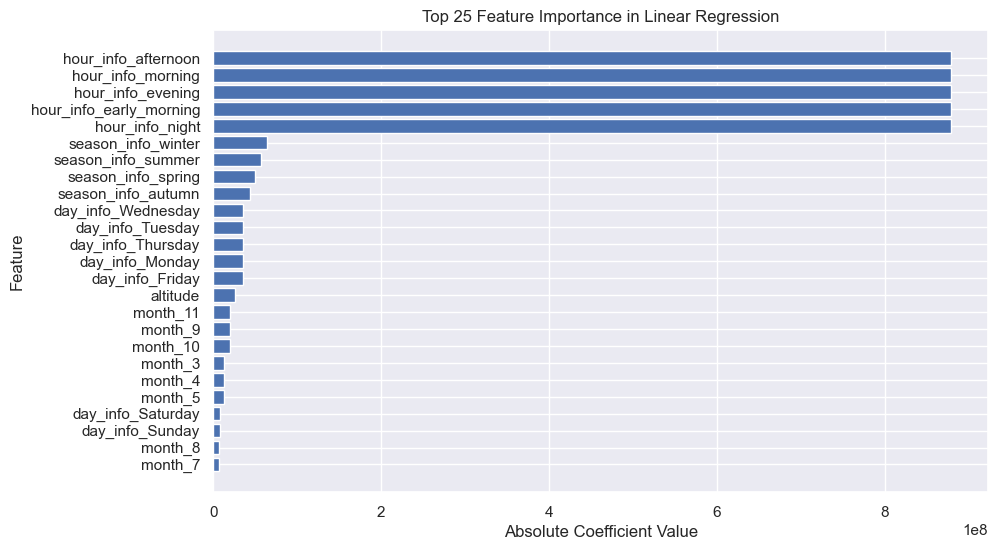

In [38]:
# Check feature importance
coefficients = model.coef_
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': coefficients
})

# Sort by absolute value of the coefficient to see the most important features
feature_importance['Abs_Coefficient'] = feature_importance['Coefficient'].abs()
feature_importance = feature_importance.sort_values(by='Abs_Coefficient', ascending=False)

# Print the top 25 most important features
print(feature_importance.head(25))

# Plot the top 25 most important features
top_25_features = feature_importance.head(25)
plt.figure(figsize=(10, 6))
plt.barh(top_25_features['Feature'], top_25_features['Abs_Coefficient'])
plt.xlabel('Absolute Coefficient Value')
plt.ylabel('Feature')
plt.title('Top 25 Feature Importance in Linear Regression')
plt.gca().invert_yaxis()  # To display the most important feature at the top
plt.show()

This code sorts features based on the absolute value of their coefficients. It shows which features have the strongest linear relationship with the target variable, whether positive or negative.

### First Kaggle submission

In [39]:
# Predict using the test set (if required)
y_pred_test = model.predict(X_test_scaled)
print(f'Test Predictions: {y_pred_test}')

Test Predictions: [0.72426569 0.71156228 0.83647954 ... 0.13466549 0.3407259  0.49352932]


In [40]:
df_output = pd.DataFrame(y_pred_test)
df_output = df_output.reset_index()
df_output.columns = ['index','percentage_docks_available']

#df_output.to_csv('Submission_12.csv',index=False)

In [41]:
df_output.head()

,index,percentage_docks_available
0,0,0.724266
1,1,0.711562
2,2,0.836480
3,3,0.858888
4,4,0.586105


In [42]:
df_output.shape

(171902, 2)

### XGBOOST model - Feature Selection

In [43]:
from numpy import sort

In [44]:
# Initialize and train the XGBoost model
xgb_model = xgb.XGBRFRegressor(
    objective='reg:logistic', 
    eval_metric='rmse'
) # , n_estimators=200, max_depth=5)

In [45]:
xgb_model.fit(X_train_scaled, y_train)

XGBRFRegressor(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bytree=None, device=None,
               early_stopping_rounds=None, enable_categorical=False,
               eval_metric='rmse', feature_types=None, gamma=None,
               grow_policy=None, importance_type=None,
               interaction_constraints=None, max_bin=None,
               max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=None, max_leaves=None,
               min_child_weight=None, missing=nan, monotone_constraints=None,
               multi_strategy=None, n_estimators=None, n_jobs=None,
               num_parallel_tree=None, objective='reg:logistic',
               random_state=None, reg_alpha=None, ...)

In [46]:
# Predict using the validation set
y_pred_xgb = xgb_model.predict(X_val_scaled)

In [47]:
# Evaluate the model
mse = mean_squared_error(y_val, y_pred_xgb)
r2 = r2_score(y_val, y_pred_xgb)

In [48]:
print(f'Mean Squared Error: {mse}')
print(f'R^2 Score: {r2}')

# Optionally, show the first few predictions vs actual values
comparison = pd.DataFrame({'Actual': y_val, 'Predicted': y_pred_xgb})
print(comparison.head())

Mean Squared Error: 0.011648233506643875
R^2 Score: 0.8338834527091364
     Actual  Predicted
0  0.479630   0.517651
1  0.633333   0.690978
2  0.509259   0.540868
3  0.993939   0.824347
4  0.796296   0.813005


In [49]:
mean_squared_error(y_train, xgb_model.predict(X_train_scaled), squared=False)

0.11463220254263003

In [50]:
P_valid = xgb_model.predict(X_val_scaled)

In [51]:
mean_squared_error(y_val, P_valid, squared=False)

0.10792698229193604

<Figure size 1000x800 with 0 Axes>

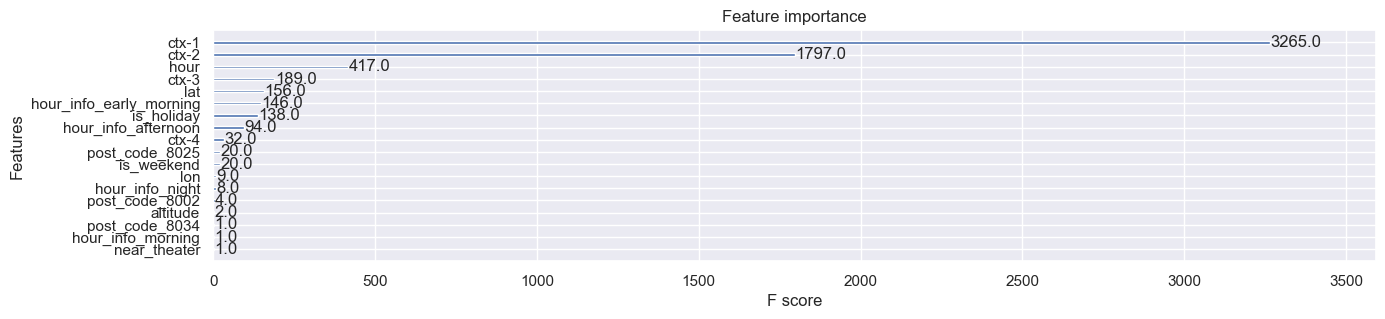

In [52]:
# Set the feature names
xgb_model.get_booster().feature_names = X_train.columns.tolist()

# Plot feature importance
plt.figure(figsize=(10, 8))
plot_importance(xgb_model.get_booster(), importance_type='weight')
plt.show()

This uses the plot_importance function from XGBoost to visualize the importance of features based on how frequently they are used to split the data (weight). This measure includes non-linear interactions and splits across all trees.

### Neural Networks

In [57]:
# Select just the features
features = ['ctx-1', 'ctx-2', 'hour', 'ctx-3', 'lat', 'hour_info_early_morning', 'is_holiday',
            'hour_info_afternoon', 'ctx-4', 'post_code_8025', 'is_weekend', 'lon', 'hour_info_night',
           'post_code_8002', 'altitude', 'post_code_8034', 'hour_info_morning', 'near_theater']

In [58]:
# Train
y_train = train[target]
X_train = train[features]

# Validation
y_val = validation[target]
X_val = validation[features]

# Test
X_test = test[features]

features_to_standardize = ['hour', 'ctx-1', 'ctx-2', 'ctx-3', 'ctx-4', 'lat', 'lon', 'altitude']

from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer

transformer = ColumnTransformer(
    transformers=[
        ('std', MinMaxScaler(), features_to_standardize)],
    remainder="passthrough"
)

X_train_scaled = transformer.fit_transform(X_train)
X_val_scaled = transformer.transform(X_val)
X_test_scaled = transformer.transform(X_test)

In [59]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

In [60]:
# Define the neural network model
# features = train.columns[train.columns != target]
model = Sequential()
model.add(Dense(256, input_dim=len(features), activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='linear'))  # For regression, the output layer should have 1 unit and 'linear' activation

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0005), loss='mean_squared_error')

# Train the model
history = model.fit(X_train_scaled, y_train, epochs=10, batch_size=10024, validation_data=(X_val_scaled, y_val), verbose=1)

Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 12s 66ms/step - loss: 0.0516 - val_loss: 0.0104
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 10s 62ms/step - loss: 0.0119 - val_loss: 0.0100
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 11s 67ms/step - loss: 0.0116 - val_loss: 0.0100
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 11s 66ms/step - loss: 0.0114 - val_loss: 0.0098
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 11s 64ms/step - loss: 0.0113 - val_loss: 0.0098
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 11s 67ms/step - loss: 0.0112 - val_loss: 0.0097
Epoch 7/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 12s 70ms/step - loss: 0.0112 - val_loss: 0.0097
Epoch 8/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 12s 76ms/step - loss: 0.0111 - val_loss: 0.0096
Epoch 9/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 11s 67ms/step - loss: 0.0111 - val_loss: 0.0096
Epoch 10/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 11s 68ms/step - loss: 0.0110 - val_loss: 0.0096


In [61]:
# Predict using the validation set
y_pred = model.predict(X_val_scaled).flatten()  # Flatten to convert to 1D array

# Evaluate the model
mse = mean_squared_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R^2 Score: {r2}')

# Optionally, show the first few predictions vs actual values
comparison = pd.DataFrame({'Actual': y_val, 'Predicted': y_pred})
print(comparison.head())

12711/12711 ━━━━━━━━━━━━━━━━━━━━ 15s 1ms/step
Mean Squared Error: 0.009627357791455874
R^2 Score: 0.8627033502600835
     Actual  Predicted
0  0.479630   0.489266
1  0.633333   0.667856
2  0.509259   0.502658
3  0.993939   0.909021
4  0.796296   0.834544


In [63]:
# Predict using the test set
y_pred_test = model.predict(X_test_scaled)

5372/5372 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step


In [65]:
df_output = pd.DataFrame(y_pred_test)
df_output = df_output.reset_index()
df_output.columns = ['index','percentage_docks_available']

df_output.to_csv('Submission_12_NN.csv',index=False)

In [66]:
df_output.head()

,index,percentage_docks_available
0,0,0.762679
1,1,0.719911
2,2,0.851946
3,3,0.872717
4,4,0.621900


In [67]:
# Let's check again feature importance

In [68]:
# Initialize and train the XGBoost model
xgb_model = xgb.XGBRFRegressor(
    objective='reg:logistic', 
    eval_metric='rmse'
) # , n_estimators=200, max_depth=5)

In [69]:
xgb_model.fit(X_train_scaled, y_train)

XGBRFRegressor(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bytree=None, device=None,
               early_stopping_rounds=None, enable_categorical=False,
               eval_metric='rmse', feature_types=None, gamma=None,
               grow_policy=None, importance_type=None,
               interaction_constraints=None, max_bin=None,
               max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=None, max_leaves=None,
               min_child_weight=None, missing=nan, monotone_constraints=None,
               multi_strategy=None, n_estimators=None, n_jobs=None,
               num_parallel_tree=None, objective='reg:logistic',
               random_state=None, reg_alpha=None, ...)

In [70]:
# Predict using the validation set
y_pred_xgb = xgb_model.predict(X_val_scaled)

In [71]:
# Evaluate the model
mse = mean_squared_error(y_val, y_pred_xgb)
r2 = r2_score(y_val, y_pred_xgb)

In [72]:
print(f'Mean Squared Error: {mse}')
print(f'R^2 Score: {r2}')

# Optionally, show the first few predictions vs actual values
comparison = pd.DataFrame({'Actual': y_val, 'Predicted': y_pred_xgb})
print(comparison.head())

Mean Squared Error: 0.011640051362819625
R^2 Score: 0.8340001390273448
     Actual  Predicted
0  0.479630   0.527177
1  0.633333   0.685999
2  0.509259   0.543547
3  0.993939   0.824031
4  0.796296   0.811103


In [73]:
mean_squared_error(y_train, xgb_model.predict(X_train_scaled), squared=False)

0.11462348650377449

In [74]:
P_valid = xgb_model.predict(X_val_scaled)

In [75]:
mean_squared_error(y_val, P_valid, squared=False)

0.10788906970967738

<Figure size 1000x800 with 0 Axes>

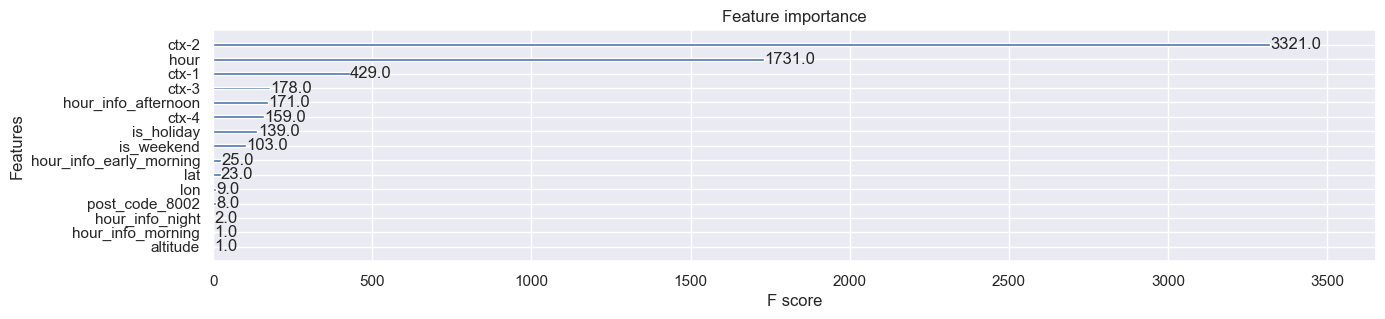

In [76]:
# Set the feature names
xgb_model.get_booster().feature_names = X_train.columns.tolist()

# Plot feature importance
plt.figure(figsize=(10, 8))
plot_importance(xgb_model.get_booster(), importance_type='weight')
plt.show()